# Notebook setup

In [1]:
!pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl

In [2]:
from google.colab import drive
import os
import zipfile
import shutil

drive.mount('/content/drive') #mount Google Drive

import os
import shutil


def copy_folder_contents(source_folder, destination_folder):
    for item in os.listdir(source_folder):
        item_path = os.path.join(source_folder, item)
        destination_path = os.path.join(destination_folder, item)

        if os.path.isfile(item_path):
            shutil.copy(item_path, destination_path)
        elif os.path.isdir(item_path):
            os.makedirs(destination_path, exist_ok=True)
            copy_folder_contents(item_path, destination_path)



source_folder = "/content/drive/My Drive/CardioCare"
destination_folder = "/content/CardioCare"


os.makedirs(destination_folder, exist_ok=True)
#copy folders from drive to runtime
copy_folder_contents(source_folder, destination_folder)




# Get dataset from drive
zip_file_path = "/content/drive/My Drive/ecg.zip"
extraction_path = "/content/dataset"
os.makedirs(extraction_path, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)
extracted_files = os.listdir(extraction_path)
print("Extracted files:", extracted_files)


print("Files Loaded!!!")


Mounted at /content/drive
Extracted files: ['test', 'train', 'val']
Files Loaded!!!


## Data Loaders

### for inceptionv3

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"
val_dir = "/content/dataset/val"
# Define image transformations (optional)
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# Create the dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### for alexnet

In [4]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"
val_dir = "/content/dataset/val"
# Define image transformations (optional)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Initial Training (DL Models)

## AlexNet

In [ ]:
import torch
from torchvision import models
import math
import time

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Devide used: {device}")

# Load pre-trained AlexNet model
alexnet = models.alexnet(weights='AlexNet_Weights.DEFAULT')

# Freeze feature extraction layers (optional)
for param in alexnet.features[:].parameters():
    param.requires_grad = False  # Freeze weights of feature extraction layers
# Get the number of features output by the pre-trained alexnet
num_ftrs = alexnet.classifier[6].in_features
num_classes = 4
alexnet.classifier[6] = torch.nn.Linear(num_ftrs, num_classes)


# Define loss function (e.g., Cross-Entropy loss for classification)
criterion = torch.nn.CrossEntropyLoss()
# Define optimizer (e.g., Adam optimizer)
optimizer = torch.optim.Adam(alexnet.parameters(), lr=0.001)  # Adjust learning rate as needed

num_batches = len(train_loader)

num_epochs = 30
alexnet.to(device)
for epoch in range(num_epochs):
    # Train and validate the alexnet
    alexnet.train()
    start = time.time()
    train_loss = 0.0
    print(f'Epoch: {epoch+1}')
    batch = 0;
    for image, label in train_loader:
      image, label = image.to(device), label.to(device)
      batch += 1
      print(f'Batch {batch}/{num_batches}',end='')

      optimizer.zero_grad()
      output = alexnet(image)

      loss = criterion(output, label)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      print(f'\r',end='')

    # Validate the model
    alexnet.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for image, label in val_loader:
            image, label = image.to(device), label.to(device)
            output = alexnet(image)
            loss = criterion(output, label)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    # Calculate accuracy
    val_accuracy = 100 * correct / total

    end_time = time.time()
    epoch_time = end_time - start

    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},\n\t\t Val Accuracy: {val_accuracy:.4f}, Time Taken: {epoch_time:.2f} seconds")

# Save the trained alexnet
torch.save(alexnet.state_dict(), "/content/CardioCare/alexnet.pth")
print("Model saved successfully!")


Devide used: cuda


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 152MB/s]


Epoch: 1
Epoch: 1/25, Train Loss: 25.6579, Val Loss: 8.3551,
		 Val Accuracy: 25.7716, Time Taken: 55.36 seconds
Epoch: 2
Epoch: 2/25, Train Loss: 4.5524, Val Loss: 8.0789,
		 Val Accuracy: 45.9877, Time Taken: 54.29 seconds
Epoch: 3
Epoch: 3/25, Train Loss: 4.2569, Val Loss: 7.6285,
		 Val Accuracy: 42.7469, Time Taken: 56.11 seconds
Epoch: 4
Epoch: 4/25, Train Loss: 4.0661, Val Loss: 7.0126,
		 Val Accuracy: 50.4630, Time Taken: 54.54 seconds
Epoch: 5
Epoch: 5/25, Train Loss: 3.7751, Val Loss: 6.5410,
		 Val Accuracy: 55.7099, Time Taken: 54.60 seconds
Epoch: 6
Epoch: 6/25, Train Loss: 3.4696, Val Loss: 6.2765,
		 Val Accuracy: 57.4074, Time Taken: 55.26 seconds
Epoch: 7
Epoch: 7/25, Train Loss: 3.3601, Val Loss: 5.8947,
		 Val Accuracy: 60.6481, Time Taken: 54.41 seconds
Epoch: 8
Epoch: 8/25, Train Loss: 3.2105, Val Loss: 5.5500,
		 Val Accuracy: 65.5864, Time Taken: 54.19 seconds
Epoch: 9
Epoch: 9/25, Train Loss: 3.0436, Val Loss: 5.2805,
		 Val Accuracy: 68.3642, Time Taken: 54.73

In [ ]:
# Testing the model
test_loss = 0.0
correct = 0
total = 0
start_time = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = 100 * correct / total

end_time = time.time()
testing_time = end_time - start_time

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%, Testing Time: {testing_time:.2f} seconds")

Test Loss: 0.0387, Test Accuracy: 98.61%, Testing Time: 26.92 seconds


## SqueezeNet

In [ ]:
import torch
from torchvision import models
import math
import time

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Devide used: {device}")

# Load pre-trained squeezenet model
squeezenet = models.squeezenet1_1(weights='SqueezeNet1_1_Weights.DEFAULT')

# Freeze feature extraction layers (optional)
squeezenet.classifier._modules["1"] = torch.nn.Conv2d(512, 5, kernel_size=(1, 1))
squeezenet.num_classes = 4
for param in squeezenet.parameters():
    param.requires_grad = False
for param in squeezenet.classifier.parameters():
    param.requires_grad = True


# Define loss function (e.g., Cross-Entropy loss for classification)
criterion = torch.nn.CrossEntropyLoss()
# Define optimizer (e.g., Adam optimizer)
optimizer = torch.optim.Adam(squeezenet.parameters(), lr=0.01)  # Adjust learning rate as needed

num_batches = len(train_loader)

num_epochs = 50
squeezenet.to(device)
for epoch in range(40,num_epochs):
    # Train and validate the squeezenet
    squeezenet.train()
    start = time.time()
    train_loss = 0.0
    print(f'Epoch: {epoch+1}')
    batch = 0;
    for image, label in train_loader:
      image, label = image.to(device), label.to(device)
      batch += 1
      print(f'Batch {batch}/{num_batches}',end='')

      optimizer.zero_grad()
      output = squeezenet(image)

      loss = criterion(output, label)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      print(f'\r',end='')

    # Validate the model
    squeezenet.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for image, label in val_loader:
            image, label = image.to(device), label.to(device)
            output = squeezenet(image)
            loss = criterion(output, label)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    # Calculate accuracy
    val_accuracy = 100 * correct / total

    end_time = time.time()
    epoch_time = end_time - start

    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},\n\t\t Val Accuracy: {val_accuracy:.4f}, Time Taken: {epoch_time:.2f} seconds")

# Save the trained squeezenet
torch.save(squeezenet.state_dict(), "/content/CardioCare/squeezenet.pth")
print("Model saved successfully!")


In [ ]:
# Testing the model
test_loss = 0.0
correct = 0
total = 0
start_time = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = squeezenet(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = 100 * correct / total

end_time = time.time()
testing_time = end_time - start_time

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%, Testing Time: {testing_time:.2f} seconds")

## InceptionV3


### Training

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import inception_v3

# Assuming you have defined your train_loader and val_loader

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

# Load pre-trained InceptionV3 model
inceptionv3 = inception_v3(weights='DEFAULT')

# Modify the last fully connected layer to match the number of classes in your dataset
num_classes = 4  # Adjust according to your dataset
num_ftrs = inceptionv3.fc.in_features
inceptionv3.fc = nn.Linear(num_ftrs, num_classes)

# Define loss function (e.g., Cross-Entropy loss for classification)
criterion = nn.CrossEntropyLoss()

# Define optimizer (e.g., Adam optimizer)
optimizer = optim.Adam(inceptionv3.parameters())

num_batches = len(train_loader)
num_epochs = 30

inceptionv3.to(device)

for epoch in range(num_epochs):
    # Train and validate the InceptionV3 model
    inceptionv3.train()
    start = time.time()
    train_loss = 0.0
    print(f'Epoch: {epoch+1}')
    batch = 0

    for image, label in train_loader:
        image, label = image.to(device), label.to(device)
        batch += 1
        print(f'Batch {batch}/{num_batches}', end='')

        optimizer.zero_grad()
        output, _ = inceptionv3(image)

        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        print(f'\r', end='')

    # Validate the model
    inceptionv3.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for image, label in val_loader:
            image, label = image.to(device), label.to(device)
            output = inceptionv3(image)
            loss = criterion(output, label)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    # Calculate accuracy
    val_accuracy = 100 * correct / total

    end_time = time.time()
    epoch_time = end_time - start

    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},\n\t\t Val Accuracy: {val_accuracy:.4f}, Time Taken: {epoch_time:.2f} seconds")

# Save the trained InceptionV3 model
torch.save(inceptionv3.state_dict(), "/content/CardioCare/inceptionv3.pth")
print("Model saved successfully!")


### Testing


In [ ]:
# Testing the model
test_loss = 0.0
correct = 0
total = 0
start_time = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inceptionv3(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = 100 * correct / total

end_time = time.time()
testing_time = end_time - start_time

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%, Testing Time: {testing_time:.2f} seconds")

Model saved successfully!
Test Loss: 1.3756, Test Accuracy: 30.56%, Testing Time: 44.96 seconds


## CustomCNN

### Defining CustomCNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
  def __init__(self):
    super(CustomCNN, self).__init__()

    #define the  layers
    self.conv01 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1)
    self.maxpool01 = nn.MaxPool2d(kernel_size=6,stride=3)
    self.conv02 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
    self.maxpool02 = nn.MaxPool2d(kernel_size=6, stride=3)
    self.conv03 = nn.Conv2d(in_channels = 128, out_channels=224, kernel_size=3, stride=2, padding=1)
    self.maxpool03 = nn.MaxPool2d(kernel_size=1, stride=2)
    self.fc01 = nn.Linear(224*224*3,16)
    self.dropout01_fc = nn.Dropout2d(0.2)
    self.conv04 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2, padding=2, stride=2)
    self.conv05 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=2, stride=2)
    self.dropout02 = nn.Dropout(0.2)
    self.dropout03 = nn.Dropout(0.2)
    self.conv07 = nn.Conv2d(in_channels=320, out_channels=256, kernel_size=1, stride=1)
    self.dropout07 = nn.Dropout(0.3)
    self.fc02 = nn.Linear(2*2*256,512)
    self.dropout02_fc = nn.Dropout(0.3)
    self.fc03 = nn.Linear(512,4)

    self.batchnorm01_fc = nn.BatchNorm2d(16)
    self.batchnorm05 = nn.BatchNorm2d(64)
    self.batchnorm04 = nn.BatchNorm2d(32)
    self.batchnorm01 = nn.BatchNorm2d(64)
    self.batchnorm02 = nn.BatchNorm2d(128)
    self.batchnorm03 = nn.BatchNorm2d(224)
    self.batchnorm07 = nn.BatchNorm2d(256)
    self.batchnorm02_fc = nn.BatchNorm2d(512)

  def forward(self,x):
    #input is branched into 2, branch1 (b1) and branch2 (b2)

    #Branch 1
    b1 = self.fc01(x.view(x.size(0), -1))
    b1 = F.leaky_relu(b1,0.1)

    b1 = b1.unsqueeze(2).unsqueeze(3)
    # Apply batch normalization
    b1 = self.batchnorm01_fc(b1)
    # Remove the dummy dimensions after batch normalization
    #b1 = b1.squeeze(2).squeeze(2)
    b1 = self.dropout01_fc(b1)
    #Branch 1a
    b1a = self.conv05(b1)
    b1a = F.leaky_relu(b1a,0.1)
    b1a = self.batchnorm05(b1a)
    #Branch 1b
    b1b = self.conv04(b1)
    b1b = F.leaky_relu(b1b,0.1)
    b1b = self.batchnorm04(b1b)
    #Merge Branch1a and Branch1b
    b1 = torch.cat((b1a,b1b),dim=1)
    b1 = self.dropout02(b1)


    #Branch 2
    b2 = self.conv01(x)
    b2 = F.leaky_relu(b2,0.1)
    b2 = self.batchnorm01(b2)
    b2 = self.maxpool01(b2)
    b2 = self.conv02(b2)
    b2 = F.leaky_relu(b2,0.1)
    b2 = self.batchnorm02(b2)
    b2 = self.maxpool02(b2)
    b2 = self.conv03(b2)
    b2 = F.leaky_relu(b2,0.1)
    b2 = self.batchnorm03(b2)
    b2 = self.maxpool03(b2)


    #Merge Branch 1 and Branch 2
    x = torch.cat((b1,b2),dim=1)
    x = self.dropout03(x)
    x = self.conv07(x)
    x = F.leaky_relu(x,0.1)
    x = self.batchnorm07(x)
    x = self.dropout07(x)

    x = x.view(x.size(0), -1)
    x = self.fc02(x)
    x = F.leaky_relu(x,0.1)

    x = x.unsqueeze(2).unsqueeze(3)
    # Apply batch normalization
    x = self.batchnorm02_fc(x)
    # Remove the dummy dimensions after batch normalization
    x = x.squeeze(2).squeeze(2)

    x = self.dropout02(x)
    x = F.softmax(x,dim=-1)
    return x




### Training the model

In [ ]:
import torch.optim as optim
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Devide used: {device}")
cardiocare = CustomCNN()
# Define loss function (e.g., Cross-Entropy loss for classification)
criterion = torch.nn.CrossEntropyLoss()
# Define optimizer (e.g., Adam optimizer)
optimizer = torch.optim.Adam(cardiocare.parameters(), lr=0.1)  # Adjust learning rate as needed

num_batches = len(train_loader)

num_epochs = 30
cardiocare.to(device)
for epoch in range(num_epochs):
    # Train and validate the cardiocare
    cardiocare.train()
    start = time.time()
    train_loss = 0.0
    print(f'Epoch: {epoch+1}')
    batch = 0;
    for image, label in train_loader:
      image, label = image.to(device), label.to(device)
      batch += 1
      print(f'Batch {batch}/{num_batches}',end='')

      optimizer.zero_grad()
      output = cardiocare(image)

      loss = criterion(output, label)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      print(f'\r',end='')

    # Validate the model
    cardiocare.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for image, label in val_loader:
            image, label = image.to(device), label.to(device)
            output = cardiocare(image)
            loss = criterion(output, label)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()

    # Calculate accuracy
    val_accuracy = 100 * correct / total

    end_time = time.time()
    epoch_time = end_time - start

    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},\n\t\t Val Accuracy: {val_accuracy:.4f}, Time Taken: {epoch_time:.2f} seconds")

# Save the trained cardiocare
torch.save(cardiocare.state_dict(), "/content/CardioCare/cardiocare.pth")
print("Model saved successfully!")


### Testing CustomCNN

In [ ]:
torch.save(cardiocare.state_dict(), "/content/CardioCare/cardiocare.pth")
print("Model saved successfully!")
# Testing the model
test_loss = 0.0
correct = 0
total = 0
start_time = time.time()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cardiocare(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test accuracy
test_accuracy = 100 * correct / total

end_time = time.time()
testing_time = end_time - start_time

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%, Testing Time: {testing_time:.2f} seconds")

Model saved successfully!
Test Loss: 6.2409, Test Accuracy: 0.00%, Testing Time: 29.26 seconds


# Testing

## Testing AlexNet

In [ ]:
import torch
from torchvision import models
import math
import time

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")
# Load pre-trained AlexNet model
alexnet = models.alexnet(weights='AlexNet_Weights.DEFAULT')
# Freeze feature extraction layers (optional)
for param in alexnet.features[:].parameters():
    param.requires_grad = False  # Freeze weights of feature extraction layers
# Get the number of features output by the pre-trained alexnet
num_ftrs = alexnet.classifier[6].in_features
num_classes = 4
alexnet.classifier[6] = torch.nn.Linear(num_ftrs, num_classes)
# Define loss function (e.g., Cross-Entropy loss for classification)
criterion = torch.nn.CrossEntropyLoss()
alexnet.load_state_dict(torch.load('/content/CardioCare/alexnet.pth',map_location=device))

# Initialize variables for precision, recall, F1-score, and accuracy
precision = 0.0
recall = 0.0
f1_score = 0.0
accuracy = 0.0

# Initialize variables for true positives, false positives, and false negatives
tp = 0
fp = 0
fn = 0
test_loss = 0.0
correct = 0
total = 0

# Iterate over test dataset to compute TP, FP, FN
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        tp += ((predicted == 1) & (labels == 1)).sum().item()
        fp += ((predicted == 1) & (labels == 0)).sum().item()
        fn += ((predicted == 0) & (labels == 1)).sum().item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute precision, recall, and F1-score
if tp + fp > 0:
    precision = tp / (tp + fp)
if tp + fn > 0:
    recall = tp / (tp + fn)
if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)

# Compute accuracy
accuracy = 100 * correct / total

# Print precision, recall, F1-score, and accuracy
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.2f}%")


Devide used: cpu
Precision: 0.9940
Recall: 1.0000
F1-score: 0.9970
Accuracy: 98.15%


## Testing SqueezeNet

In [ ]:
import torch
from torchvision import models
import math
import time

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Devide used: {device}")
# Load pre-trained squeezenet model
squeezenet = models.squeezenet1_1(weights='SqueezeNet1_1_Weights.DEFAULT')

# Freeze feature extraction layers (optional)
squeezenet.classifier._modules["1"] = torch.nn.Conv2d(512, 5, kernel_size=(1, 1))
squeezenet.num_classes = 4
# Define loss function (e.g., Cross-Entropy loss for classification)
criterion = torch.nn.CrossEntropyLoss()
squeezenet.load_state_dict(torch.load('/content/CardioCare/squeezenet.pth',map_location=device))

# Initialize variables for precision, recall, F1-score, and accuracy
precision = 0.0
recall = 0.0
f1_score = 0.0
accuracy = 0.0

# Initialize variables for true positives, false positives, and false negatives
tp = 0
fp = 0
fn = 0
test_loss = 0.0
correct = 0
total = 0

# Iterate over test dataset to compute TP, FP, FN
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = squeezenet(images)
        _, predicted = torch.max(outputs.data, 1)
        tp += ((predicted == 1) & (labels == 1)).sum().item()
        fp += ((predicted == 1) & (labels == 0)).sum().item()
        fn += ((predicted == 0) & (labels == 1)).sum().item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute precision, recall, and F1-score
if tp + fp > 0:
    precision = tp / (tp + fp)
if tp + fn > 0:
    recall = tp / (tp + fn)
if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)

# Compute accuracy
accuracy = 100 * correct / total

# Print precision, recall, F1-score, and accuracy
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.2f}%")


Devide used: cpu


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 32.6MB/s]


Precision: 0.9371
Recall: 0.9504
F1-score: 0.9437
Accuracy: 79.32%


## Testing CustomCNN



In [ ]:
import torch
from torchvision import models
import math
import time

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Devide used: {device}")
# Load pre-trained cardiocare model
cardiocare = CustomCNN()

# Define loss function (e.g., Cross-Entropy loss for classification)
criterion = torch.nn.CrossEntropyLoss()
cardiocare.load_state_dict(torch.load('/content/CardioCare/cardiocare.pth',map_location=device))

# Initialize variables for precision, recall, F1-score, and accuracy
precision = 0.0
recall = 0.0
f1_score = 0.0
accuracy = 0.0

# Initialize variables for true positives, false positives, and false negatives
tp = 0
fp = 0
fn = 0
test_loss = 0.0
correct = 0
total = 0

# Iterate over test dataset to compute TP, FP, FN
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cardiocare(images)
        _, predicted = torch.max(outputs.data, 1)
        tp += ((predicted == 1) & (labels == 1)).sum().item()
        fp += ((predicted == 1) & (labels == 0)).sum().item()
        fn += ((predicted == 0) & (labels == 1)).sum().item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute precision, recall, and F1-score
if tp + fp > 0:
    precision = tp / (tp + fp)
if tp + fn > 0:
    recall = tp / (tp + fn)
if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)

# Compute accuracy
accuracy = 100 * correct / total

# Print precision, recall, F1-score, and accuracy
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.2f}%")


## Testing InceptionV3



In [ ]:
import torch
from torchvision.models import inception_v3
import math
import time

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Devide used: {device}")
# Load pre-trained cardiocare model
inceptionv3 = inception_v3(weights='DEFAULT')

# Modify the last fully connected layer to match the number of classes in your dataset
num_classes = 4  # Adjust according to your dataset
num_ftrs = inceptionv3.fc.in_features
inceptionv3.fc = nn.Linear(num_ftrs, num_classes)

# Define loss function (e.g., Cross-Entropy loss for classification)
criterion = torch.nn.CrossEntropyLoss()
inceptionv3.load_state_dict(torch.load('/content/CardioCare/inceptionv3.pth',map_location=device))

# Initialize variables for precision, recall, F1-score, and accuracy
precision = 0.0
recall = 0.0
f1_score = 0.0
accuracy = 0.0

# Initialize variables for true positives, false positives, and false negatives
tp = 0
fp = 0
fn = 0
test_loss = 0.0
correct = 0
total = 0

# Iterate over test dataset to compute TP, FP, FN
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs,_ = inceptionv3(images)
        _, predicted = torch.max(outputs.data, 1)
        tp += ((predicted == 1) & (labels == 1)).sum().item()
        fp += ((predicted == 1) & (labels == 0)).sum().item()
        fn += ((predicted == 0) & (labels == 1)).sum().item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute precision, recall, and F1-score
if tp + fp > 0:
    precision = tp / (tp + fp)
if tp + fn > 0:
    recall = tp / (tp + fn)
if precision + recall > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)

# Compute accuracy
accuracy = 100 * correct / total

# Print precision, recall, F1-score, and accuracy
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.2f}%")


Devide used: cpu
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Accuracy: 29.94%


# ML Models

## Feature Extractor

In [ ]:
import numpy as np
import torch
from torchvision import models
import torch.nn as nn

def extract_features(dataloader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Device used: {device}")
  alexnet = models.alexnet(weights='AlexNet_Weights.DEFAULT')
  num_ftrs = alexnet.classifier[6].in_features
  num_classes = 4
  alexnet.classifier[6] = torch.nn.Linear(num_ftrs, num_classes)
  features = []
  labels = []
  alexnet.eval()
  alexnet = nn.Sequential(*list(alexnet.features.children()))
  with torch.no_grad():
      for images, targets in dataloader:
          features_batch = alexnet(images).detach().numpy()
          features.append(features_batch)
          labels.append(targets.numpy())
  features = np.concatenate(features)
  labels = np.concatenate(labels)

  features = features.reshape(features.shape[0], -1)
  return features, labels

# Extract features from the dataset
X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(test_loader)

## Random Forest

In [ ]:
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate the trained model
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Device used: cpu
Device used: cpu
Accuracy: 1.0


## SVM

In [ ]:
import torch.nn as nn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train, y_train)

# Evaluate the trained model
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


## Decision tree

In [ ]:
import torch.nn as nn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Evaluate the trained model
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


## KNN

In [ ]:
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Extract features from the dataset
features, labels = extract_features(train_loader)

# Reshape the features
num_samples = features.shape[0]
features = features.reshape(num_samples, -1)  # Flatten features

# Step 2: Prepare data for kNN
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Step 3: Train kNN Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors as needed
knn_classifier.fit(X_train, y_train)

# Evaluate the trained model
y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Device used: cpu
Accuracy: 0.823076923076923


## Save ML Models

In [ ]:
import joblib

# Save Random Forest Classifier
joblib.dump(rf_classifier, '/content/CardioCare/random_forest_model.pkl')

# Save Decision Tree Classifier
joblib.dump(dt_classifier, '/content/CardioCare/decision_tree_model.pkl')

# Save kNN Classifier
joblib.dump(knn_classifier, '/content/CardioCare/knn_model.pkl')

# Save SVM Classifier
joblib.dump(svm_classifier, '/content/CardioCare/svm_model.pkl')


['/content/CardioCare/svm_model.pkl']

## Performance Metrics

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load the saved models
loaded_rf_model = joblib.load('random_forest_model.pkl')
loaded_dt_model = joblib.load('decision_tree_model.pkl')
loaded_knn_model = joblib.load('knn_model.pkl')
loaded_svm_model = joblib.load('svm_model.pkl')

# Define a function to evaluate a model
def evaluate_model(model, X_test, y_test):
    # Predict
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    return precision, recall, f1, accuracy

# Evaluate all four models
rf_precision, rf_recall, rf_f1, rf_accuracy = evaluate_model(loaded_rf_model, X_test, y_test)
dt_precision, dt_recall, dt_f1, dt_accuracy = evaluate_model(loaded_dt_model, X_test, y_test)
knn_precision, knn_recall, knn_f1, knn_accuracy = evaluate_model(loaded_knn_model, X_test, y_test)
svm_precision, svm_recall, svm_f1, svm_accuracy = evaluate_model(loaded_svm_model, X_test, y_test)

# Print the evaluation results
print("Random Forest:")
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)
print("Accuracy:", rf_accuracy)
print()

print("Decision Tree:")
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1-score:", dt_f1)
print("Accuracy:", dt_accuracy)
print()

print("k-Nearest Neighbors:")
print("Precision:", knn_precision)
print("Recall:", knn_recall)
print("F1-score:", knn_f1)
print("Accuracy:", knn_accuracy)
print()

print("Support Vector Machine:")
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1-score:", svm_f1)
print("Accuracy:", svm_accuracy)


Random Forest:
Precision: 0.9264145610487072
Recall: 0.9230769230769231
F1-score: 0.922073863334659
Accuracy: 0.9230769230769231

Decision Tree:
Precision: 0.9027725479648556
Recall: 0.9
F1-score: 0.8986886025800054
Accuracy: 0.9

k-Nearest Neighbors:
Precision: 0.8370738228064926
Recall: 0.823076923076923
F1-score: 0.8183064865991695
Accuracy: 0.823076923076923

Support Vector Machine:
Precision: 0.9848290598290598
Recall: 0.9846153846153847
F1-score: 0.9846182737450343
Accuracy: 0.9846153846153847


# Adversarial Training

## Defense Training

In [ ]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time
import torchattacks
import math

model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
num_ftrs = model.classifier[6].in_features
num_classes = 4
model.classifier[6] = nn.Linear(num_ftrs, num_classes)


last_fc_idx = len(list(model.features.children()))
print("Total number of layers in features: ", last_fc_idx)

# Freeze most layers except the last 30% of features
for idx, layer in enumerate(model.features.children()):
    if idx < (last_fc_idx * 0.7):
        for param in layer.parameters():
            param.requires_grad = False




num_samples = len(train_dataset)
batch_size = train_loader.batch_size
num_batches = math.ceil(num_samples / batch_size)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/content/CardioCare/alexnet.pth'))
model = model.to(device)
print("Device used: ",device)
# Step 4: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


num_epochs = 15
model.train()
# Define the PGD attack
pgd = torchattacks.PGD(model, eps=0.007, alpha=0.002,steps=8)
pgd.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #setting normalization used to the attack object
fgsm = torchattacks.FGSM(model, eps=0.02)
fgsm.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #setting normalization used to the attack object
df = torchattacks.DeepFool(model,steps=10)
df.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #setting normalization used to the attack object


fgsm_fract = 0.5
df_fract = 0.5
pgd_fract = 0.5

f1,f2,f3 = 0,int(batch_size*fgsm_fract),batch_size
df1,df2,df3 = 0,int(batch_size*df_fract),batch_size
pgd1,pgd2,pgd3 = 0,int(batch_size*pgd_fract),batch_size

for epoch in range(num_epochs, num_epochs*2):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    model.train()
    print(f'FGSM Epoch started: {epoch+1}/{num_epochs}')
    start_time = time.time()
    count = 1
    #training against fgsm
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        print(f"FGSM Batch: {count}/{num_batches}",end='')
        count+=1
        # Generate adversarial examples FGSM
        fgsm_imgs = fgsm(images[f1:f2], labels[f1:f2]) #next 20 images
        fgsm_imgs.to(device)
        # Concatenate adversarial examples with clean inputs
        inputs = torch.cat([fgsm_imgs, images[f2:f3]], dim=0)

        # Perform one step of training
        optimizer.zero_grad()
        outputs = model(inputs)
        logits = outputs
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        print('\r', end='')

    epoch_loss = running_loss / len(train_loader)
    end_time=time.time()
    epoch_run_time=end_time-start_time
    accuracy = (correct_predictions / total_predictions) * 100.0
    print(f'\nFGSM Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {time.time() - start_time:.2f} seconds')


    print(f'PGD Epoch started: {epoch+1}/{num_epochs}')
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    count=1
    start_time = time.time()
    #training against PGD
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        print(f"Batch: {count}/{num_batches}",end='')
        count+=1
        # Generate adversarial examples FGSM
        pgd_imgs = pgd(images[pgd1:pgd2], labels[pgd1:pgd2]) #next 20 images
        pgd_imgs.to(device)
        # Concatenate adversarial examples with clean inputs
        inputs = torch.cat([pgd_imgs, images[pgd2:pgd3]], dim=0)

        # Perform one step of training
        optimizer.zero_grad()
        outputs = model(inputs)
        logits = outputs
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        print('\r', end='')

    epoch_loss = running_loss / len(train_loader)
    end_time=time.time()
    epoch_run_time=end_time-start_time
    accuracy = (correct_predictions / total_predictions) * 100.0
    print(f'\nPGD Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {time.time() - start_time:.2f} seconds')\

    print(f'DeepFool Epoch started: {epoch+1}/{num_epochs}')
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    count=1
    start_time = time.time()
    #training against deepfool
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        print(f"Batch: {count}/{num_batches}",end='')
        count+=1
        # Generate adversarial examples FGSM
        df_imgs = df(images[df1:df2], labels[df1:df2]) #next 20 images
        df_imgs.to(device)
        # Concatenate adversarial examples with clean inputs
        inputs = torch.cat([df_imgs, images[df2:df3]], dim=0)

        # Perform one step of training
        optimizer.zero_grad()
        outputs = model(inputs)
        logits = outputs
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        print('\r', end='')

    epoch_loss = running_loss / len(train_loader)
    end_time=time.time()
    epoch_run_time=end_time-start_time
    accuracy = (correct_predictions / total_predictions) * 100.0
    print(f'\nDeepFool Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {time.time() - start_time:.2f} seconds')

torch.save(model.state_dict(), '/content/CardioCare/advtrained.pth')


## Defense Testing

In [ ]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time
import torchattacks
import os
from PIL import Image
import math




def find_accuracy_2(model):
  criterion = nn.CrossEntropyLoss()
  # Step 4:attack objects
  fgsm = torchattacks.FGSM(model,eps=0.02)
  fgsm.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  df = torchattacks.DeepFool(model)
  df.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  pgd = torchattacks.PGD(model,eps=0.007,alpha=0.002)
  pgd.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  # Replace the generator expressions with explicit tensors for mean and std
  mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
  std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)


  correct_original = 0
  correct_adversarial_fgsm = 0
  correct_adversarial_pgd = 0
  correct_adversarial_df = 0
  total_samples = 0

  pure_loss = 0.0
  fgsm_loss = 0.0
  pgd_loss = 0.0
  df_loss = 0.0

  num_samples = len(test_dataset)
  batch_size = test_loader.batch_size
  num_batches = math.ceil(num_samples / batch_size)

  half_batch, batch = batch_size//2, batch_size

  count = 1
  for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      print(f'Batch: {count}/{num_batches}',end='')
      count+=1
      # Original classification
      outputs = model(images)
      loss = criterion(outputs, labels)
      pure_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      correct_original += (predicted == labels).sum().item()

      # Adversarial attack FGSM
      adversarial_images = fgsm(images[:half_batch], labels[:half_batch])
      adversarial_images = torch.cat((adversarial_images,images[half_batch:batch]),dim=0)
      outputs_adv = model(adversarial_images)
      loss = criterion(outputs_adv, labels)
      fgsm_loss += loss.item()
      _, predicted_adv = torch.max(outputs_adv.data, 1)
      correct_adversarial_fgsm += (predicted_adv == labels).sum().item()

      # Adversarial attack PGD
      adversarial_images = pgd(images[:half_batch], labels[:half_batch])
      adversarial_images = torch.cat((adversarial_images,images[half_batch:batch]),dim=0)
      outputs_adv = model(adversarial_images)
      loss = criterion(outputs_adv, labels)
      pgd_loss += loss.item()
      _, predicted_adv = torch.max(outputs_adv.data, 1)
      correct_adversarial_pgd += (predicted_adv == labels).sum().item()

      # Adversarial attack DeepFool
      adversarial_images = df(images[:half_batch], labels[:half_batch])
      adversarial_images = torch.cat((adversarial_images,images[half_batch:batch]),dim=0)
      outputs_adv = model(adversarial_images)
      loss = criterion(outputs_adv, labels)
      df_loss += loss.item()
      _, predicted_adv = torch.max(outputs_adv.data, 1)
      correct_adversarial_df += (predicted_adv == labels).sum().item()

      total_samples += labels.size(0)
      print('\r',end='')

  accuracy_original = 100 * correct_original / total_samples
  accuracy_adversarial_fgsm = 100 * correct_adversarial_fgsm / total_samples
  accuracy_adversarial_pgd = 100 * correct_adversarial_pgd / total_samples
  accuracy_adversarial_df = 100 * correct_adversarial_df / total_samples

  pure_loss /= len(test_loader)
  fgsm_loss /= len(test_loader)
  pgd_loss /= len(test_loader)
  df_loss /= len(test_loader)

  print(f"Original images:\nTest Accuracy = {accuracy_original:.2f}%, Test Loss = {pure_loss:.3f}")
  print(f"FGSM images:\nTest Accuracy = {accuracy_adversarial_fgsm:.2f}%, Test Loss = {fgsm_loss:.3f}")
  print(f"DeepFool images:\nTest Accuracy = {accuracy_adversarial_df:.2f}%, Test Loss = {df_loss:.3f}")
  print(f"PGD images:\nTest Accuracy = {accuracy_adversarial_pgd:.2f}%, Test Loss = {pgd_loss:.3f}")


# Step 3: Model Initialization
model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
num_ftrs = model.classifier[6].in_features
num_classes = 4
model.classifier[6] = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Device used: ",device)

model.load_state_dict(torch.load('/content/CardioCare/alexnet.pth'))
print("Baseline Model Accuracy:")
find_accuracy_2(model)

print("\n")
model.load_state_dict(torch.load('/content/CardioCare/advtrained.pth'))
print("Adversarial Trained Accuracy:")
find_accuracy_2(model)


Device used:  cuda
Baseline Model Accuracy:
Original images:
Test Accuracy = 97.69%, Test Loss = 0.080
FGSM images:
Test Accuracy = 49.07%, Test Loss = 6.544
DeepFool images:
Test Accuracy = 71.91%, Test Loss = 0.758
PGD images:
Test Accuracy = 48.46%, Test Loss = 11.798


Adversarial Trained Accuracy:
Original images:
Test Accuracy = 95.06%, Test Loss = 0.397
FGSM images:
Test Accuracy = 77.01%, Test Loss = 0.740
DeepFool images:
Test Accuracy = 71.30%, Test Loss = 0.727
PGD images:
Test Accuracy = 60.65%, Test Loss = 1.348


# Demonstrate Adversarial Defence


Device used:  cuda


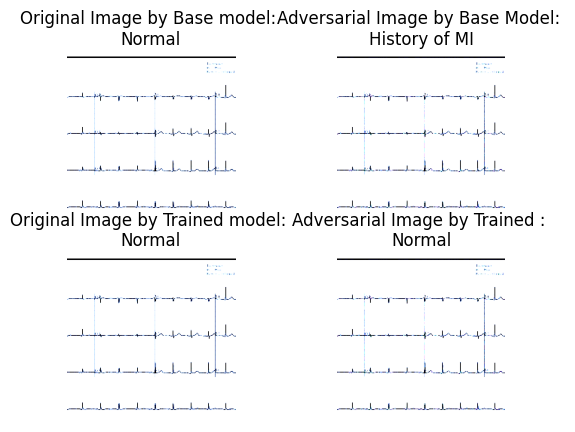

In [15]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import time
import torchattacks
import math
from PIL import Image
import matplotlib.pyplot as plt
pred_classes = ('Arrhythmia', 'Myocardial Infarction', 'Normal', 'History of MI')


model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
num_ftrs = model.classifier[6].in_features
num_classes = 4
model.classifier[6] = nn.Linear(num_ftrs, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('/content/CardioCare/alexnet.pth'))
model = model.to(device)
print("Device used: ",device)
model.eval()
# Define the PGD attack
fgsm = torchattacks.FGSM(model, eps=0.02)
fgsm.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #setting normalization used to the attack object


def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image


# Load an image
image_path = '/content/dataset/test/Normal Person/Normal(100).jpg'
image = preprocess_image(image_path)

# Generate the adversarial image
adversarial_image = fgsm(image, torch.tensor([2]))

# Plot the images

img = image.to(device)
adv_img = adversarial_image.to(device)

original_image = image.squeeze(0).permute(1, 2, 0).numpy()
output = model(img)
_, predicted = torch.max(output, 1)
plt.subplot(2,2,1)
plt.imshow(original_image)
plt.title(f'Original Image by Base model: \n{pred_classes[predicted]}')
plt.axis('off')

adversarial_image = adversarial_image.to('cpu').squeeze(0).permute(1, 2, 0).detach().numpy()
output = model(adv_img)
_, predicted = torch.max(output, 1)
plt.subplot(2,2,2)
plt.imshow(adversarial_image)
plt.title(f'Adversarial Image by Base Model: \n{pred_classes[predicted]}')
plt.axis('off')


model.load_state_dict(torch.load('/content/CardioCare/advtrained.pth'))
output = model(img)
_, predicted = torch.max(output, 1)
plt.subplot(2,2,3)
plt.imshow(original_image)
plt.title(f'Original Image by Trained model: \n{pred_classes[predicted]}')
plt.axis('off')

output = model(adv_img)
_, predicted = torch.max(output, 1)
plt.subplot(2,2,4)
plt.imshow(adversarial_image)
plt.title(f'Adversarial Image by Trained : \n{pred_classes[predicted]}')
plt.axis('off')

plt.show()

# Utilities

## Save Work

In [ ]:
from google.colab import drive
import os
import shutil

drive.mount('/content/drive') #mount Google Drive

import os
import shutil


def copy_folder_contents(source_folder, destination_folder):
    for item in os.listdir(source_folder):
        item_path = os.path.join(source_folder, item)
        destination_path = os.path.join(destination_folder, item)

        if os.path.isfile(item_path):
            shutil.copy(item_path, destination_path)
        elif os.path.isdir(item_path):
            os.makedirs(destination_path, exist_ok=True)
            copy_folder_contents(item_path, destination_path)



source_folder = "/content/CardioCare"
destination_folder = "/content/drive/My Drive/CardioCare"
os.makedirs(destination_folder, exist_ok=True)

copy_folder_contents(source_folder, destination_folder)


print("Files Saved!!!")


## Citations

In [ ]:
#Khan, Ali Haider; Hussain, Muzammil  (2021), “ECG Images dataset of Cardiac Patients ”, Mendeley Data, V2, doi: 10.17632/gwbz3fsgp8.2